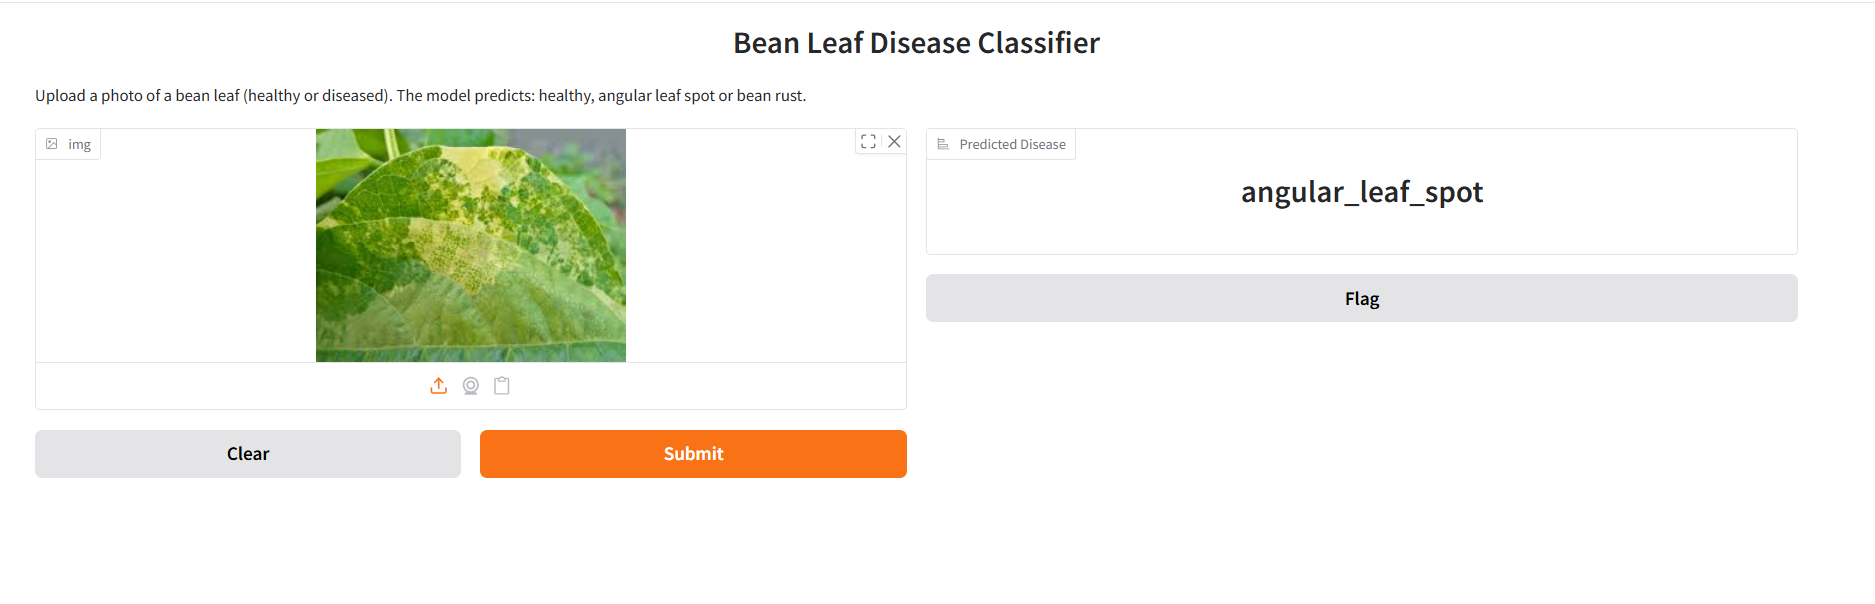

# Plant Disease Detection Using CNN

This is a hands-on project in which we will walk through building a plant disease detection system using Convolutional Neural Networks (CNNs), and will also deploy it as an interactive web app (with Gradio) on Hugging Face Spaces.

We will be using public dataset.

**Project Highlights** :

* Step-by-step, practical workflow (data → model → evaluation → deployment)

*  Uses the Beans dataset (plant leaf disease detection, easy to load with TensorFlow Datasets)
*  Makes a real-world, usable tool for farmers, gardeners, or research
No complex downloading—run everything in Google Colab

## 1. Project Overview
**Goal**: Classify bean leaves into "healthy," "angular leaf spot," or "bean rust" from photos. Useful in agriculture to quickly identify plant health issues.

Workflow:
* Load and understand the dataset
* Preprocess data (prepare images and labels)
* Build and train a CNN
* Evaluate the performance
* Save and export the trained model
* Build a Gradio (or Streamlit) interactive app for image upload and prediction
* Deploy to Hugging Face Spaces

### 2. Step # 1: Setting Up & Loading the Dataset

a. Install and import necessary Python packages: <br>
b. Load the Beans Dataset

The Beans dataset contains 3 classes:

*   Healthy
*   Angular leaf spot
*   Bean rust

c. viewing the sample from dataset

In [1]:
# a. ---- Install and import necessary Python packages:
!pip install tensorflow tensorflow-datasets gradio --quiet
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np


In [2]:
# b.--------Load the Beans Dataset
dataset, info = tfds.load('beans', as_supervised=True, with_info=True)
train_ds, val_ds, test_ds = dataset['train'], dataset['validation'], dataset['test']
class_names = info.features['label'].names
print("Classes:", class_names)
print("Train size:", info.splits['train'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.VLB1PA_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.VLB1PA_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.VLB1PA_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Train size: 1034


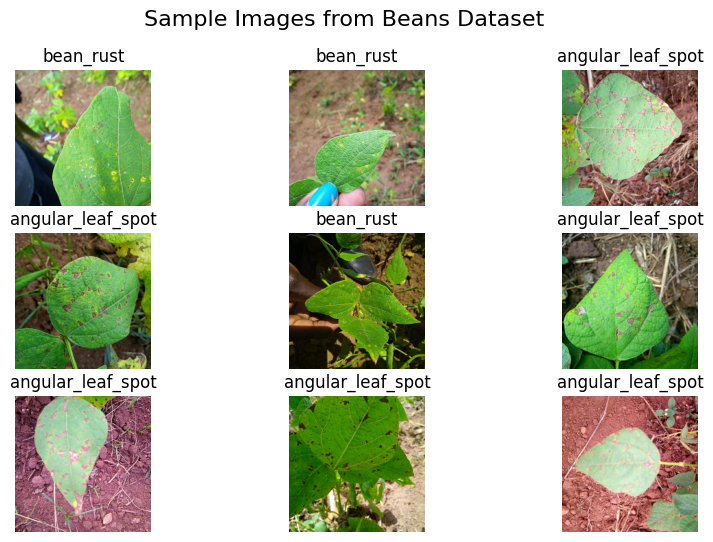

In [3]:
#c.----------loading & view sample images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(9)):  # Take 9 single elements
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[int(label.numpy())])
    plt.axis("off")
plt.suptitle("Sample Images from Beans Dataset", fontsize=16)
plt.show()


### 3. Step 2: Data Preprocessing
**a) Image Resizing & Normalization**

CNNs expect images of the same shape and normalized pixel values:

In [4]:
IMG_SIZE = 128
BATCH_SIZE = 32

# Convenience function
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

train_ds = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_ds = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)


### 4. Step 3: Building the CNN Model
We’ll use Keras to create a straightforward but effective CNN architecture:

In [5]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,139 (6.48 MB)

 Trainable params: 1,699,139 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Step 4: Model Training


In [6]:
EPOCHS = 15
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3871 - loss: 1.1299 - val_accuracy: 0.5489 - val_loss: 0.9625
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 889ms/step - accuracy: 0.5151 - loss: 0.9216 - val_accuracy: 0.6241 - val_loss: 0.8065
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 985ms/step - accuracy: 0.6142 - loss: 0.8448 - val_accuracy: 0.5940 - val_loss: 0.9033
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 896ms/step - accuracy: 0.6167 - loss: 0.8483 - val_accuracy: 0.6992 - val_loss: 0.7640
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 904ms/step - accuracy: 0.6589 - loss: 0.7456 - val_accuracy: 0.7744 - val_loss: 0.5961
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 927ms/step - accuracy: 0.7100 - loss: 0.6568 - val_accuracy: 0.7669 - val_loss: 0.5710
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 879ms/step - accuracy: 0.7557 - loss: 0.5917 - val_accuracy: 0.7669 - val_loss: 0.5567
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 906ms/step - accuracy: 0.7542 - loss: 0.5655 - val_accurac

### 6. Step 5: Model Evaluation

In [7]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.7385 - loss: 0.6828
Test accuracy: 0.77


### 7. Step 6: Save the Model for Deployment

In [8]:
model.save('beans_classifier.h5')


## Deploying on Gradio
Gradio lets users upload plant leaf images and instantly get a diagnosis.

In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image

MODEL = load_model('beans_classifier.h5')
CLASSES = class_names
IMG_SIZE = 128

def predict(img):
    img = Image.fromarray(img).resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)/255.0
    img = np.expand_dims(img, axis=0)
    preds = MODEL.predict(img)
    class_idx = np.argmax(preds[0])
    return CLASSES[class_idx]

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(),
    outputs=gr.Label(num_top_classes=3, label="Predicted Disease"),
    title="Bean Leaf Disease Classifier",
    description="Upload a photo of a bean leaf (healthy or diseased). The model predicts: healthy, angular leaf spot or bean rust."
)
iface.launch(debug=True)  # For local testing


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://26f9b0e8b47517d957.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
